<a href="https://colab.research.google.com/github/Arnab1876/Covid_data_Causal_relations/blob/main/DAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install causal-learn networkx matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 6.6 MB/s eta 0:00:00


In [5]:
!pip install pgmpy

In [6]:
pip install pandas numpy networkx matplotlib scipy seaborn

In [7]:
pip install dowhy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.1/403.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 46.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.6.7
    Uninstalling cvxpy-1.6.7:
      Successfully uninstalled cvxpy-1.6.7


Original data shape: (169185, 15)

Age column unique values:
age
TOTAL     37460
Y_GE65    32762
Y45T64    32758
Y0T44     32648
Name: count, dtype: int64

Age encoding applied:
         age  age_numeric
3      TOTAL          0.0
0      Y0T44          1.0
1     Y45T64          2.0
2     Y_GE65          3.0
9526     NaN          NaN

Found 13 numeric columns: ['year', 'week', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_vaccinations', 'new_vaccinations', 'population', 'gdp_per_capita', 'human_development_index', 'value', 'age_numeric']
Dataset shape: (169185, 16)

Data summary:
                year           week   total_cases     new_cases  total_deaths  \
count  169185.000000  169185.000000  3.079700e+04  3.355700e+04  2.912200e+04   
mean     2021.472353      25.888991  7.960270e+06  3.624306e+04  9.415344e+04   
std         1.142883      14.801636  4.614802e+07  4.834986e+05  4.713617e+05   
min      2020.000000       1.000000  1.000000e+00  0.000000e+00  1.00000

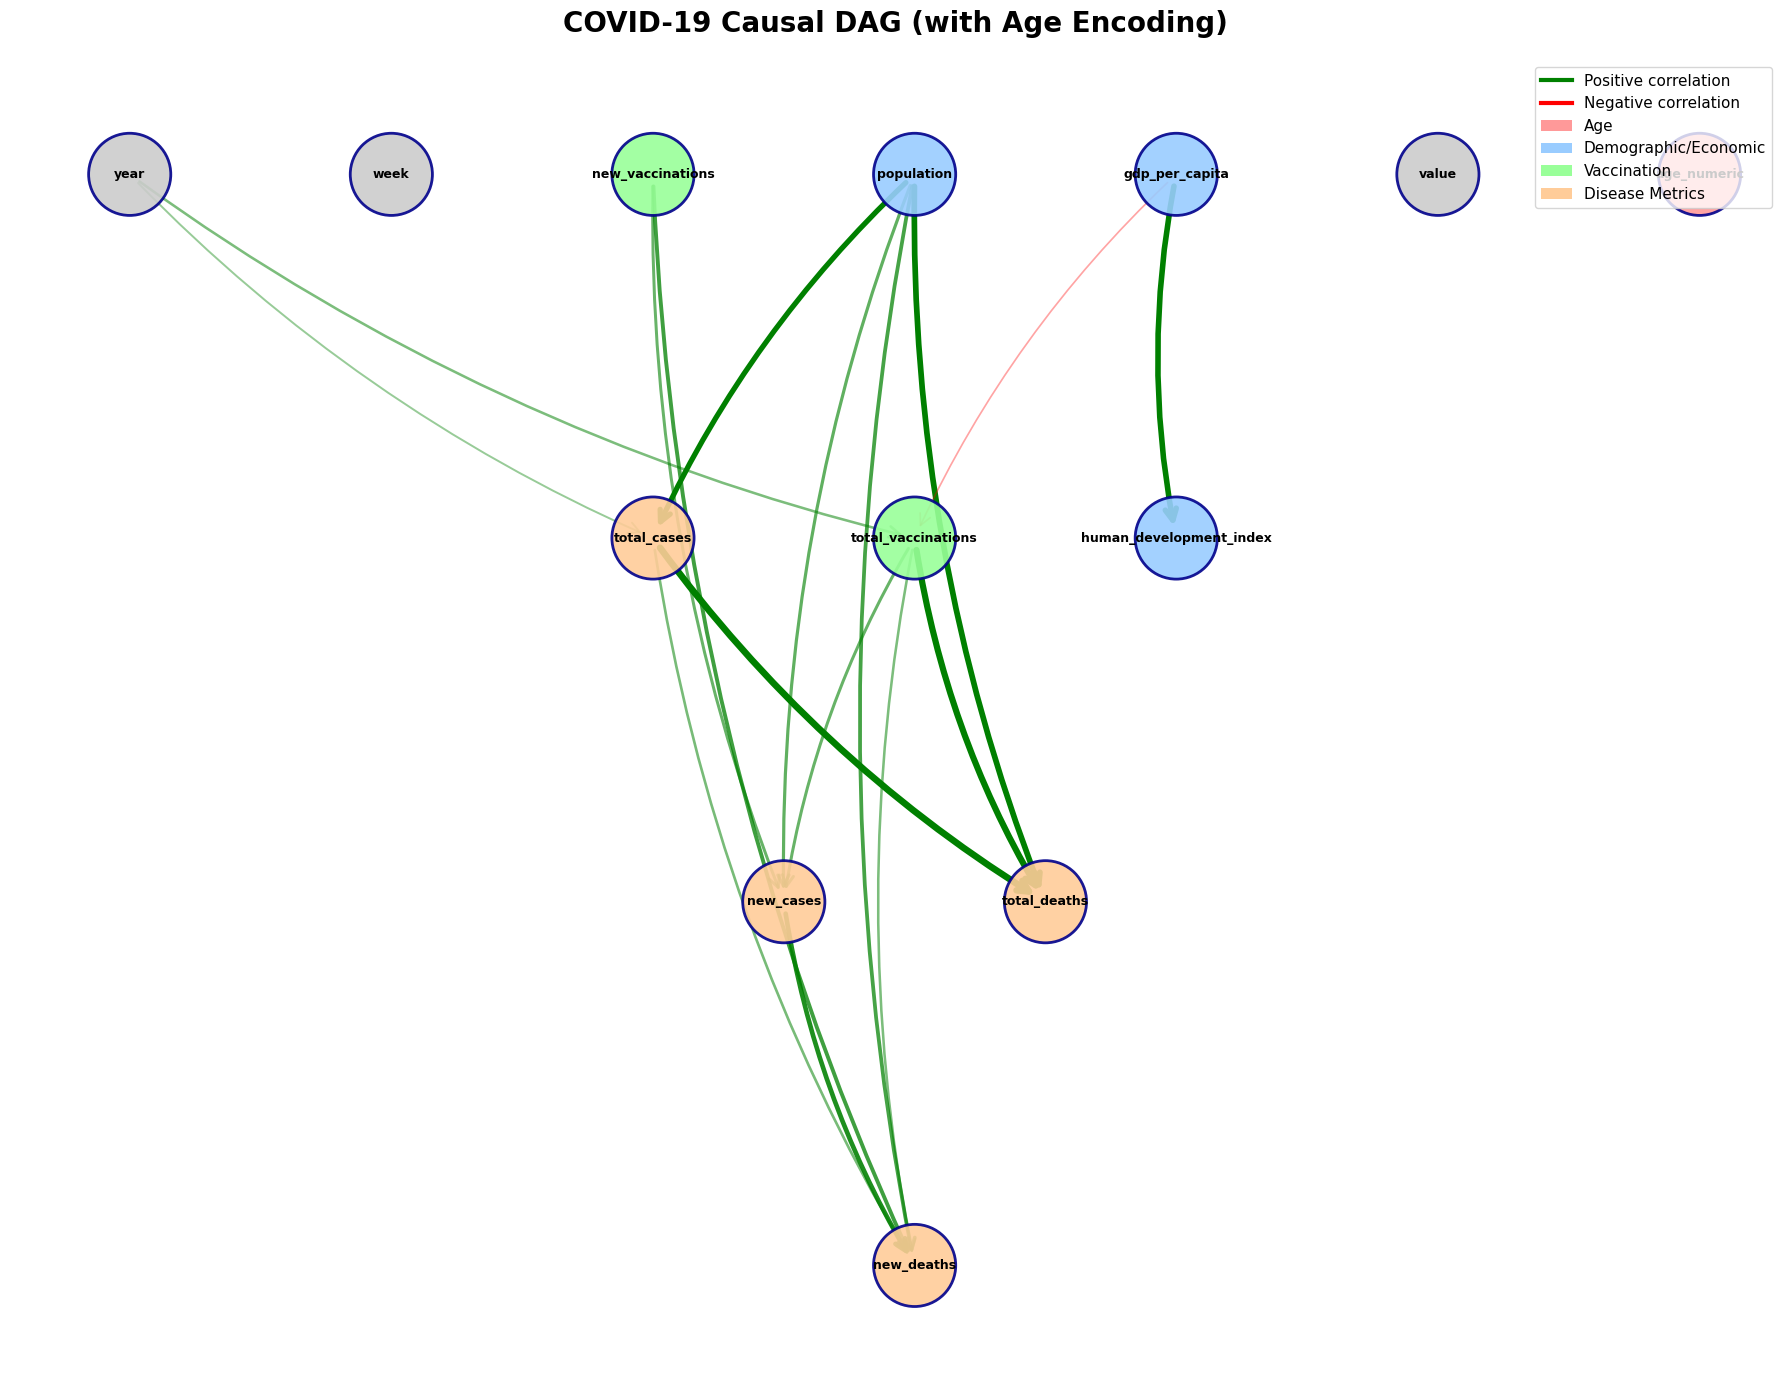


DAG Statistics:
Average in-degree: 1.23
Average out-degree: 1.23

Most influential variables (highest out-degree):
  population: 4 outgoing edges
  total_vaccinations: 3 outgoing edges
  year: 2 outgoing edges
  total_cases: 2 outgoing edges
  new_vaccinations: 2 outgoing edges

Most affected variables (highest in-degree):
  new_deaths: 5 incoming edges
  new_cases: 3 incoming edges
  total_deaths: 3 incoming edges
  total_cases: 2 incoming edges
  total_vaccinations: 2 incoming edges


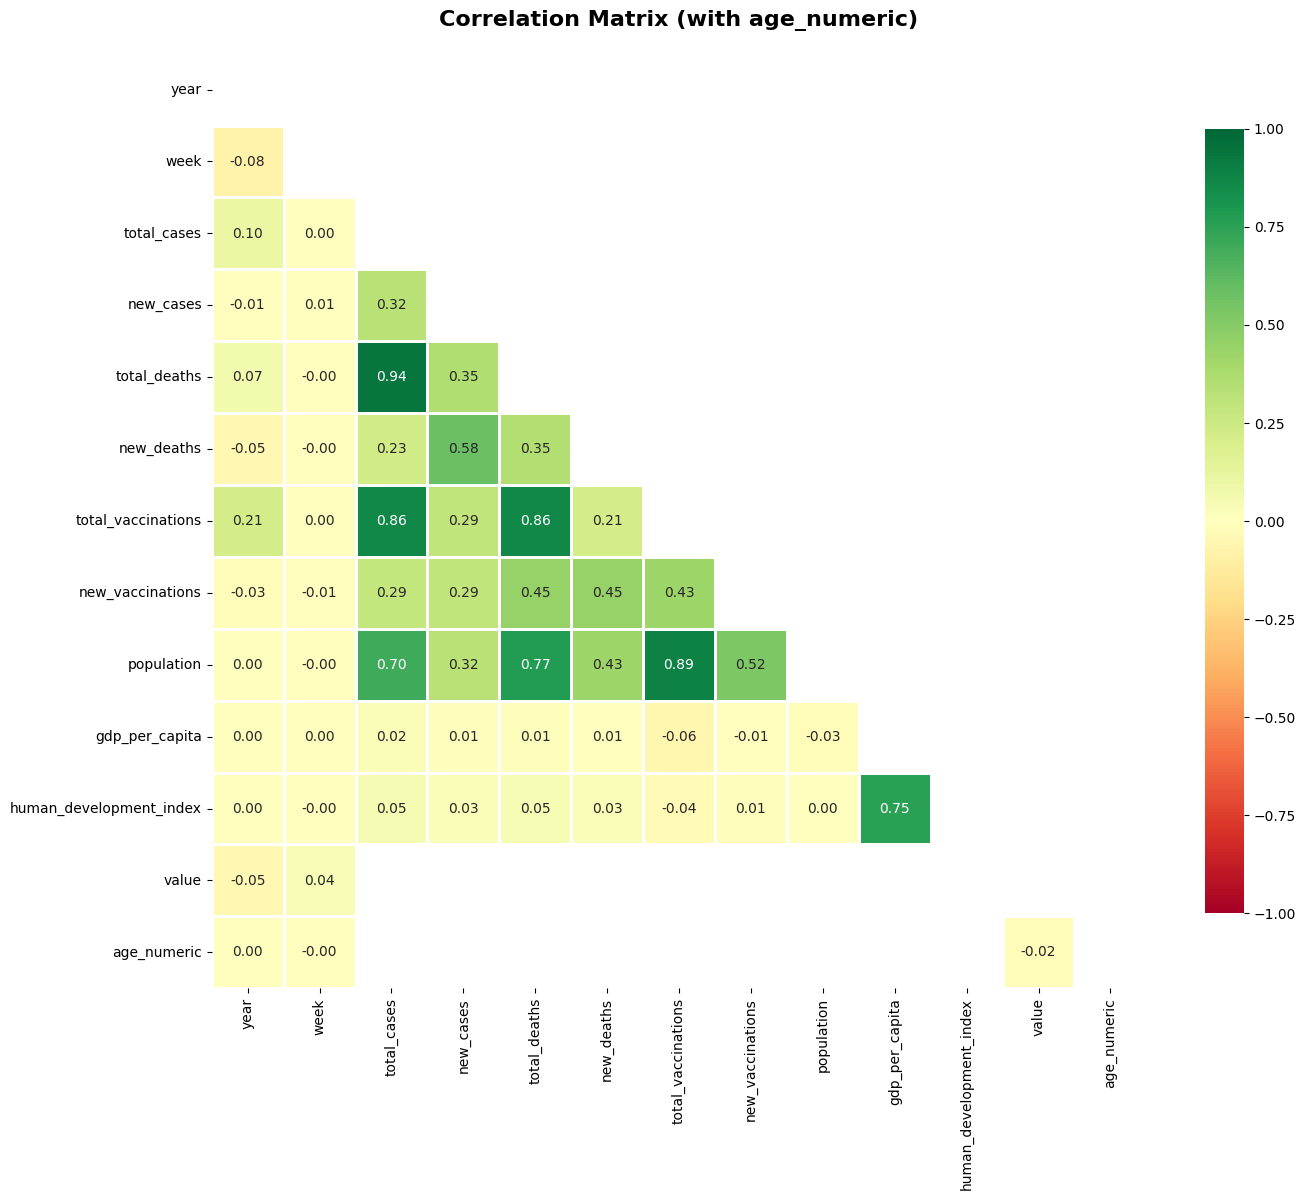

In [8]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('merged_dataset.csv')

print("Original data shape:", df.shape)
print("\nAge column unique values:")
print(df['age'].value_counts())

# Encode age column to numeric
age_encoding = {
    'TOTAL': 0,      # All age groups (baseline)
    'Y0T44': 1,      # 0-44 years (youngest group)
    'Y45T64': 2,     # 45-64 years (middle age)
    'Y_GE65': 3      # 65+ years (oldest group)
}

df['age_numeric'] = df['age'].map(age_encoding)

print("\nAge encoding applied:")
print(df[['age', 'age_numeric']].drop_duplicates().sort_values('age_numeric'))

# Get numeric columns (now including age_numeric)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nFound {len(numeric_cols)} numeric columns: {numeric_cols}")
print(f"Dataset shape: {df.shape}")

# Data summary
print(f"\nData summary:")
print(df[numeric_cols].describe())

# Check for missing values
print(f"\nMissing values per column:")
print(df[numeric_cols].isnull().sum())

# Calculate correlations
print("\nCalculating correlations...")
correlations = df[numeric_cols].corr(method='pearson')

# Show top correlations
print("\nTop 15 strongest correlations:")
corr_pairs = []
for i in range(len(correlations.columns)):
    for j in range(i+1, len(correlations.columns)):
        corr_pairs.append((correlations.columns[i], correlations.columns[j], correlations.iloc[i, j]))
corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for var1, var2, corr in corr_pairs[:15]:
    if not np.isnan(corr):
        print(f"  {var1} <-> {var2}: {corr:.3f}")

# Define causal relationships (now including age_numeric)
causal_rules = {
    # Demographic factors
    'population': ['total_cases', 'new_cases', 'total_deaths', 'new_deaths'],
    'age_numeric': ['total_deaths', 'new_deaths', 'value'],  # Age affects mortality

    # Socioeconomic factors
    'gdp_per_capita': ['total_vaccinations', 'new_vaccinations', 'human_development_index'],
    'human_development_index': ['total_vaccinations', 'new_vaccinations', 'total_deaths', 'new_deaths'],

    # Vaccination effects
    'total_vaccinations': ['new_cases', 'new_deaths', 'total_deaths'],
    'new_vaccinations': ['new_cases', 'new_deaths'],

    # Disease progression
    'total_cases': ['total_deaths', 'new_deaths'],
    'new_cases': ['new_deaths'],

    # Temporal factors
    'year': ['total_cases', 'total_vaccinations', 'new_cases'],
    'week': ['new_cases', 'new_vaccinations', 'new_deaths'],

    # Value (could be rates or other metrics)
    'value': ['total_deaths', 'new_deaths'],
}

# Build DAG
dag = nx.DiGraph()
correlation_threshold = 0.05

# Add nodes
for var in numeric_cols:
    dag.add_node(var)

# Add edges based on causal rules and correlations
edges_added = []
for cause, effects in causal_rules.items():
    if cause in numeric_cols:
        for effect in effects:
            if effect in numeric_cols:
                try:
                    corr_value = correlations.loc[cause, effect]
                    if not np.isnan(corr_value) and abs(corr_value) > correlation_threshold:
                        dag.add_edge(cause, effect, weight=abs(corr_value), correlation=corr_value)
                        edges_added.append((cause, effect, corr_value))
                except KeyError:
                    pass

# Print DAG info
print(f"\n{'='*60}")
print(f"DAG built with {dag.number_of_nodes()} nodes and {dag.number_of_edges()} edges")
print(f"{'='*60}")

if edges_added:
    print("\nCausal edges found (sorted by correlation strength):")
    edges_added.sort(key=lambda x: abs(x[2]), reverse=True)
    for cause, effect, corr in edges_added:
        direction = "+" if corr > 0 else "-"
        print(f"  {cause:25s} → {effect:25s} {direction} {abs(corr):.3f}")
else:
    print("\n No edges added with threshold 0.05! Trying without threshold...")
    # Try with no threshold
    for cause, effects in causal_rules.items():
        if cause in numeric_cols:
            for effect in effects:
                if effect in numeric_cols:
                    try:
                        corr_value = correlations.loc[cause, effect]
                        if not np.isnan(corr_value):
                            dag.add_edge(cause, effect, weight=abs(corr_value), correlation=corr_value)
                            edges_added.append((cause, effect, corr_value))
                    except KeyError:
                        pass
    print(f"Without threshold: {dag.number_of_edges()} edges added")
    if edges_added:
        edges_added.sort(key=lambda x: abs(x[2]), reverse=True)
        for cause, effect, corr in edges_added[:20]:  # Show top 20
            direction = "+" if corr > 0 else "-"
            print(f"  {cause:25s} → {effect:25s} {direction} {abs(corr):.3f}")

# Visualize DAG
if dag.number_of_edges() > 0:
    plt.figure(figsize=(18, 14), facecolor='white')

    # Use hierarchical layout for better visualization
    try:
        # Try hierarchical layout
        levels = list(nx.topological_generations(dag))
        pos = {}
        for level_idx, level_nodes in enumerate(levels):
            y = -level_idx * 2
            num_nodes = len(level_nodes)
            for node_idx, node in enumerate(level_nodes):
                x = (node_idx - num_nodes / 2) * 3
                pos[node] = (x, y)
    except:
        # Fall back to spring layout
        pos = nx.spring_layout(dag, k=3, iterations=50, seed=42)

    # Draw nodes with different colors for different variable types
    node_colors = []
    for node in dag.nodes():
        if node in ['age_numeric']:
            node_colors.append('#ff9999')  # Red for age
        elif node in ['population', 'gdp_per_capita', 'human_development_index']:
            node_colors.append('#99ccff')  # Blue for demographic/economic
        elif node in ['total_vaccinations', 'new_vaccinations']:
            node_colors.append('#99ff99')  # Green for vaccination
        elif node in ['total_cases', 'new_cases', 'total_deaths', 'new_deaths']:
            node_colors.append('#ffcc99')  # Orange for disease metrics
        else:
            node_colors.append('#cccccc')  # Gray for others

    nx.draw_networkx_nodes(dag, pos, node_color=node_colors, node_size=3500,
                           alpha=0.9, linewidths=2, edgecolors='darkblue')

    # Draw edges with color based on correlation
    for u, v, data in dag.edges(data=True):
        corr = data['correlation']
        color = 'green' if corr > 0 else 'red'
        width = 1 + abs(corr) * 4
        alpha = min(abs(corr) + 0.3, 1.0)

        nx.draw_networkx_edges(dag, pos, edgelist=[(u, v)], width=width,
                              alpha=alpha, edge_color=color, arrows=True,
                              arrowsize=20, arrowstyle='->', connectionstyle='arc3,rad=0.1')

    # Draw labels
    nx.draw_networkx_labels(dag, pos, font_size=9, font_weight='bold')

    # Title
    plt.title('COVID-19 Causal DAG (with Age Encoding)', fontsize=20, fontweight='bold', pad=20)
    plt.axis('off')

    # Legend
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    legend_elements = [
        Line2D([0], [0], color='green', linewidth=3, label='Positive correlation'),
        Line2D([0], [0], color='red', linewidth=3, label='Negative correlation'),
        Patch(facecolor='#ff9999', label='Age'),
        Patch(facecolor='#99ccff', label='Demographic/Economic'),
        Patch(facecolor='#99ff99', label='Vaccination'),
        Patch(facecolor='#ffcc99', label='Disease Metrics'),
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=11)

    plt.tight_layout()
    plt.show()

    # Network statistics
    print(f"\n{'='*60}")
    print("DAG Statistics:")
    print(f"{'='*60}")
    print(f"Average in-degree: {np.mean([d for n, d in dag.in_degree()]):.2f}")
    print(f"Average out-degree: {np.mean([d for n, d in dag.out_degree()]):.2f}")

    # Most influential nodes
    out_degrees = dict(dag.out_degree())
    print("\nMost influential variables (highest out-degree):")
    for node, degree in sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]:
        if degree > 0:
            print(f"  {node}: {degree} outgoing edges")

    # Most affected nodes
    in_degrees = dict(dag.in_degree())
    print("\nMost affected variables (highest in-degree):")
    for node, degree in sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]:
        if degree > 0:
            print(f"  {node}: {degree} incoming edges")

else:
    print("\n Cannot visualize: DAG has no edges")
    print("This might indicate very sparse or uncorrelated data")

# Show correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlations, dtype=bool))  # Show only lower triangle
sns.heatmap(correlations, annot=True, fmt='.2f', cmap='RdYlGn',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Matrix (with age_numeric)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

CONFOUNDER & CONTROL VARIABLE ANALYSIS

KEY CAUSAL RELATIONSHIPS TO ANALYZE


1️  QUESTION: Does vaccination reduce deaths?

ANALYZING: total_vaccinations → total_deaths

✓ Direct causal path(s) found:
  1. total_vaccinations → total_deaths

 CONFOUNDERS (affect both total_vaccinations and total_deaths):
  • gdp_per_capita
    └─ Creates backdoor path: gdp_per_capita → total_vaccinations and gdp_per_capita → total_deaths
  • year
    └─ Creates backdoor path: year → total_vaccinations and year → total_deaths

🔗 MEDIATORS (on causal path from total_vaccinations to total_deaths):
  None found

  COLLIDERS (do NOT control for these):
  • new_cases (has parents: population, total_vaccinations, new_vaccinations)
    └─ Controlling for this would introduce bias!
  • new_deaths (has parents: new_cases, new_vaccinations, population, total_cases, total_vaccinations)
    └─ Controlling for this would introduce bias!
  • total_cases (has parents: population, year)
    └─ Controlling for this woul

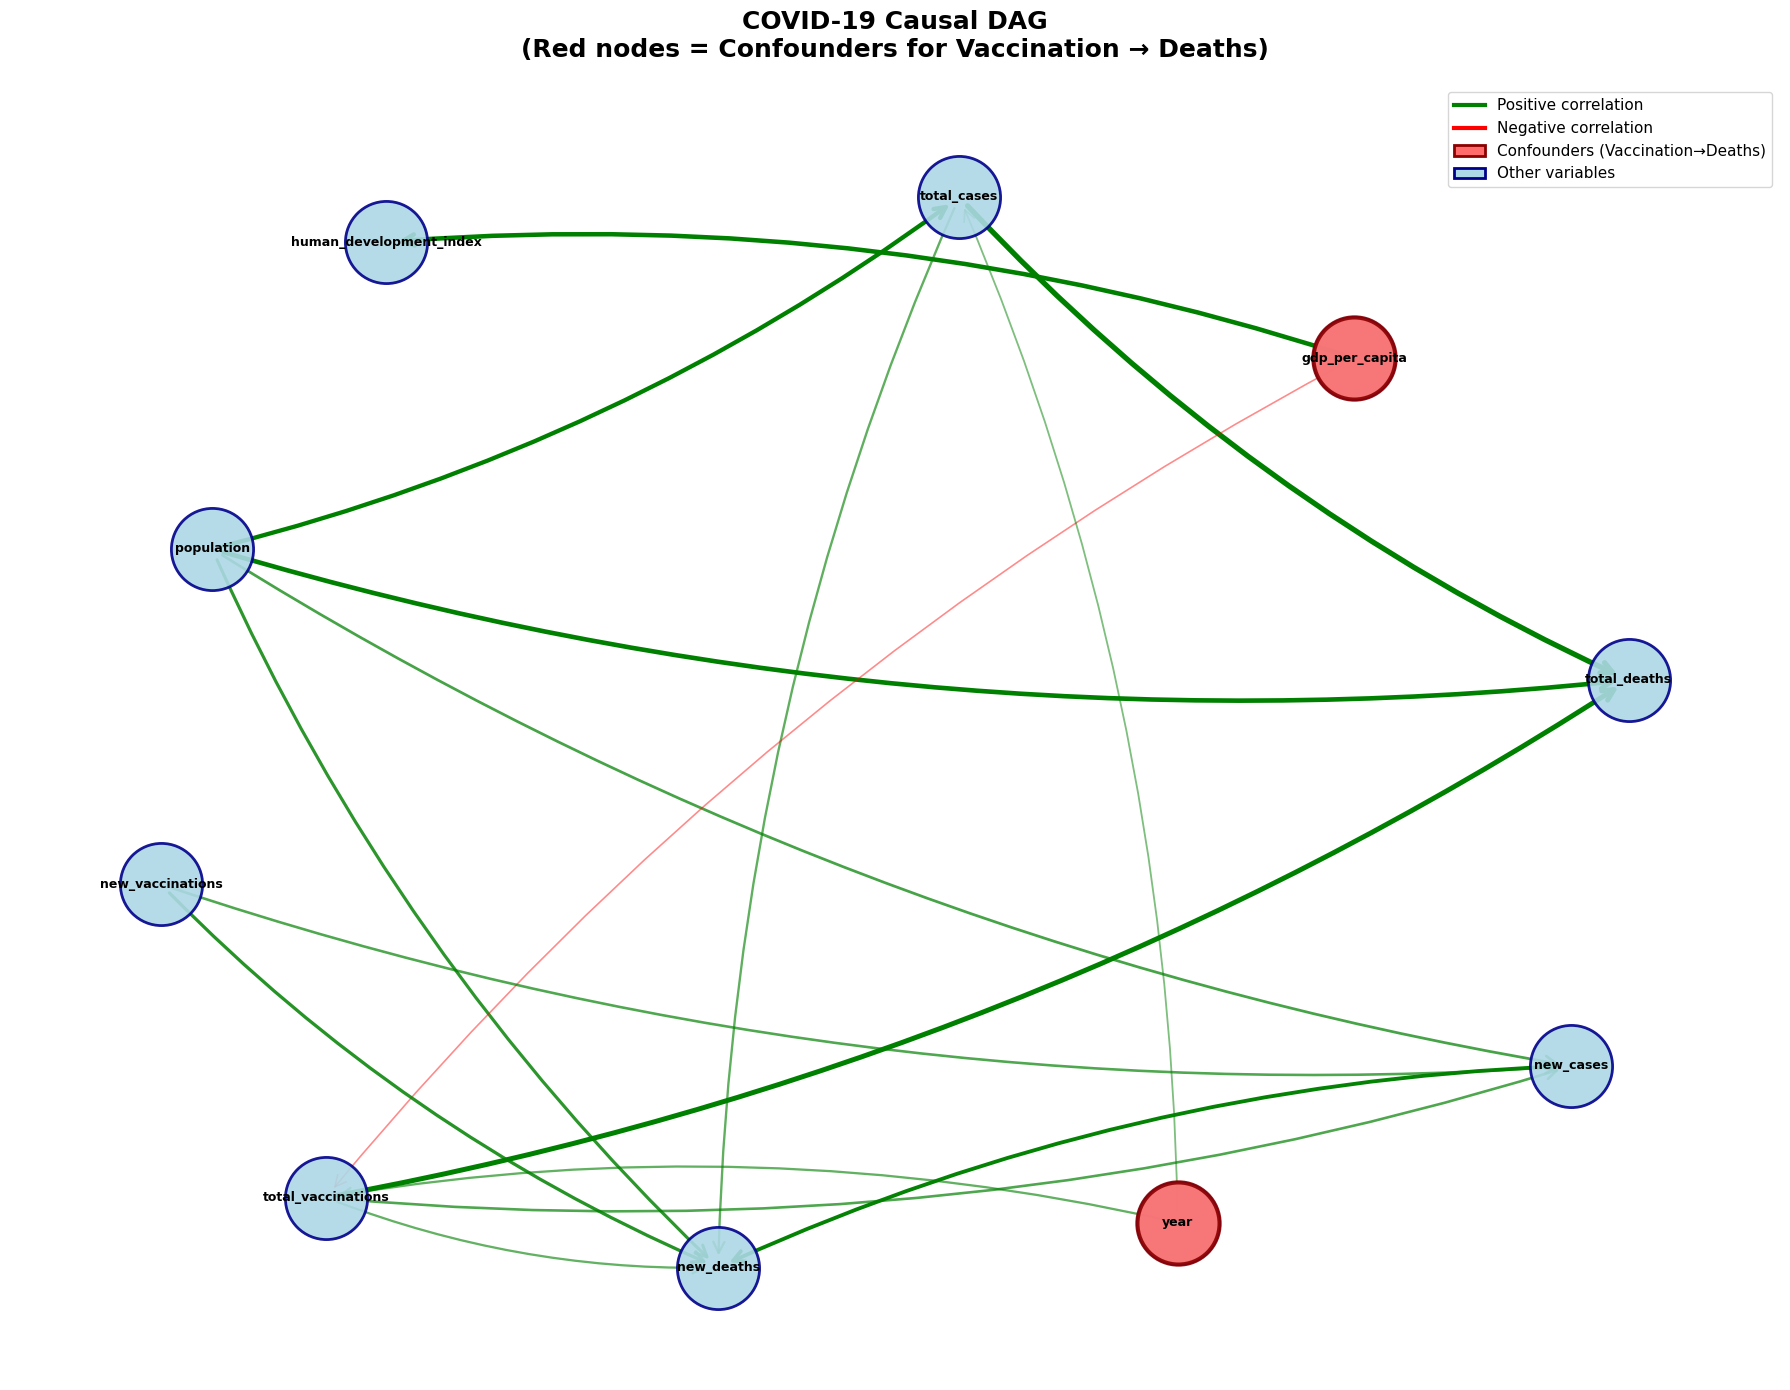


 Analysis complete!


In [9]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Reconstruct your DAG from the edges
dag = nx.DiGraph()

edges = [
    ('total_cases', 'total_deaths', 0.943),
    ('total_vaccinations', 'total_deaths', 0.863),
    ('population', 'total_deaths', 0.775),
    ('gdp_per_capita', 'human_development_index', 0.753),
    ('population', 'total_cases', 0.701),
    ('new_cases', 'new_deaths', 0.583),
    ('new_vaccinations', 'new_deaths', 0.452),
    ('population', 'new_deaths', 0.427),
    ('population', 'new_cases', 0.323),
    ('total_vaccinations', 'new_cases', 0.295),
    ('new_vaccinations', 'new_cases', 0.291),
    ('total_cases', 'new_deaths', 0.229),
    ('year', 'total_vaccinations', 0.215),
    ('total_vaccinations', 'new_deaths', 0.212),
    ('year', 'total_cases', 0.104),
    ('gdp_per_capita', 'total_vaccinations', -0.057),
]

for cause, effect, corr in edges:
    dag.add_edge(cause, effect, correlation=corr)

print("="*70)
print("CONFOUNDER & CONTROL VARIABLE ANALYSIS")
print("="*70)

def find_all_paths(G, source, target, cutoff=10):
    """Find all directed paths from source to target"""
    try:
        paths = list(nx.all_simple_paths(G, source, target, cutoff=cutoff))
        return paths
    except nx.NetworkXNoPath:
        return []

def find_backdoor_paths(G, treatment, outcome):
    """Find all backdoor paths (confounding paths)"""
    backdoor_paths = []

    # Get all parents of treatment
    treatment_parents = list(G.predecessors(treatment))

    for parent in treatment_parents:
        # Find paths from parent to outcome that don't go through treatment
        G_without_treatment = G.copy()
        G_without_treatment.remove_node(treatment)

        try:
            paths = find_all_paths(G_without_treatment, parent, outcome)
            for path in paths:
                backdoor_paths.append([parent] + path)
        except:
            pass

    return backdoor_paths

def find_confounders(G, treatment, outcome):
    """Identify confounders: variables that affect both treatment and outcome"""
    confounders = set()

    # Find all ancestors of treatment and outcome
    treatment_ancestors = nx.ancestors(G, treatment) if treatment in G else set()
    outcome_ancestors = nx.ancestors(G, outcome) if outcome in G else set()

    # Confounders are common ancestors (affect both treatment and outcome)
    confounders = treatment_ancestors.intersection(outcome_ancestors)

    return confounders

def find_mediators(G, treatment, outcome):
    """Find mediators: variables on the causal path from treatment to outcome"""
    mediators = set()

    # Find all paths from treatment to outcome
    paths = find_all_paths(G, treatment, outcome)

    for path in paths:
        # All intermediate nodes are mediators
        mediators.update(path[1:-1])

    return mediators

def find_colliders(G, treatment, outcome):
    """Find colliders: variables with two parents in the path"""
    colliders = set()

    for node in G.nodes():
        parents = list(G.predecessors(node))
        if len(parents) >= 2:
            # Check if any pair of parents are on paths between treatment and outcome
            colliders.add(node)

    return colliders

def minimal_adjustment_set(G, treatment, outcome):
    """Find minimal set of variables to control for (simplified backdoor criterion)"""
    confounders = find_confounders(G, treatment, outcome)
    mediators = find_mediators(G, treatment, outcome)

    # Adjustment set should include confounders but NOT mediators
    adjustment_set = confounders - mediators

    return adjustment_set

def analyze_causal_relationship(G, treatment, outcome):
    """Comprehensive analysis of a causal relationship"""
    print(f"\n{'='*70}")
    print(f"ANALYZING: {treatment} → {outcome}")
    print(f"{'='*70}")

    # Check if direct path exists
    direct_paths = find_all_paths(G, treatment, outcome)
    if direct_paths:
        print(f"\n✓ Direct causal path(s) found:")
        for i, path in enumerate(direct_paths, 1):
            print(f"  {i}. {' → '.join(path)}")
    else:
        print(f"\n✗ No direct causal path found")

    # Find confounders
    confounders = find_confounders(G, treatment, outcome)
    print(f"\n CONFOUNDERS (affect both {treatment} and {outcome}):")
    if confounders:
        for conf in sorted(confounders):
            # Show how it affects both
            treat_paths = find_all_paths(G, conf, treatment)
            outcome_paths = find_all_paths(G, conf, outcome)
            print(f"  • {conf}")
            print(f"    └─ Creates backdoor path: {conf} → {treatment} and {conf} → {outcome}")
    else:
        print("  None found")

    # Find mediators
    mediators = find_mediators(G, treatment, outcome)
    print(f"\n🔗 MEDIATORS (on causal path from {treatment} to {outcome}):")
    if mediators:
        for med in sorted(mediators):
            print(f"  • {med}")
            print(f"    └─ Mechanism: {treatment} → {med} → {outcome}")
    else:
        print("  None found")

    # Find colliders
    colliders = find_colliders(G, treatment, outcome)
    print(f"\n  COLLIDERS (do NOT control for these):")
    if colliders:
        for coll in sorted(colliders):
            parents = list(G.predecessors(coll))
            print(f"  • {coll} (has parents: {', '.join(parents)})")
            print(f"    └─ Controlling for this would introduce bias!")
    else:
        print("  None found")

    # Minimal adjustment set
    adjustment = minimal_adjustment_set(G, treatment, outcome)
    print(f"\n RECOMMENDED CONTROL VARIABLES:")
    if adjustment:
        print(f"  Control for: {', '.join(sorted(adjustment))}")
        print(f"\n   Your regression model should be:")
        print(f"     {outcome} ~ {treatment} + {' + '.join(sorted(adjustment))}")
    else:
        print(f"  No control variables needed!")
        print(f"\n   Your regression model should be:")
        print(f"     {outcome} ~ {treatment}")

    # Backdoor paths
    backdoor = find_backdoor_paths(G, treatment, outcome)
    if backdoor:
        print(f"\n BACKDOOR PATHS (confounding paths):")
        for i, path in enumerate(backdoor, 1):
            print(f"  {i}. {' → '.join(path)}")
        print(f"  → Block these by controlling for confounders above")

    return {
        'confounders': confounders,
        'mediators': mediators,
        'colliders': colliders,
        'adjustment_set': adjustment,
        'direct_paths': direct_paths
    }

# Analyze key causal questions
print("\n" + "="*70)
print("KEY CAUSAL RELATIONSHIPS TO ANALYZE")
print("="*70)

# 1. Effect of vaccination on deaths
print("\n\n1️  QUESTION: Does vaccination reduce deaths?")
result1 = analyze_causal_relationship(dag, 'total_vaccinations', 'total_deaths')

# 2. Effect of vaccination on cases
print("\n\n2️  QUESTION: Does vaccination reduce cases?")
result2 = analyze_causal_relationship(dag, 'total_vaccinations', 'new_cases')

# 3. Effect of cases on deaths
print("\n\n3  QUESTION: Do cases cause deaths?")
result3 = analyze_causal_relationship(dag, 'total_cases', 'total_deaths')

# 4. Effect of population on cases
print("\n\n4️  QUESTION: Does population size affect cases?")
result4 = analyze_causal_relationship(dag, 'population', 'total_cases')

# 5. Effect of GDP on vaccinations
print("\n\n5️  QUESTION: Does GDP affect vaccination rates?")
result5 = analyze_causal_relationship(dag, 'gdp_per_capita', 'total_vaccinations')

# Summary table
print("\n\n" + "="*70)
print("SUMMARY: VARIABLES TO CONTROL FOR EACH CAUSAL QUESTION")
print("="*70)

summary_data = [
    ('total_vaccinations → total_deaths', result1['adjustment_set']),
    ('total_vaccinations → new_cases', result2['adjustment_set']),
    ('total_cases → total_deaths', result3['adjustment_set']),
    ('population → total_cases', result4['adjustment_set']),
    ('gdp_per_capita → total_vaccinations', result5['adjustment_set']),
]

for relationship, controls in summary_data:
    controls_str = ', '.join(sorted(controls)) if controls else 'None'
    print(f"\n{relationship}")
    print(f"  Control for: {controls_str}")

# Visualize the DAG with annotations
print("\n\n" + "="*70)
print("Generating DAG visualization with confounder highlighting...")
print("="*70)

plt.figure(figsize=(18, 14), facecolor='white')

# Layout
pos = nx.spring_layout(dag, k=3, iterations=50, seed=42)

# Draw all nodes first
nx.draw_networkx_nodes(dag, pos, node_color='lightblue', node_size=3500,
                       alpha=0.9, linewidths=2, edgecolors='darkblue')

# Highlight confounders for vaccination → deaths
confounders_to_highlight = result1['confounders']
if confounders_to_highlight:
    nx.draw_networkx_nodes(dag, pos, nodelist=list(confounders_to_highlight),
                          node_color='#ff6b6b', node_size=3500,
                          alpha=0.9, linewidths=3, edgecolors='darkred')

# Draw edges
for u, v, data in dag.edges(data=True):
    corr = data['correlation']
    color = 'green' if corr > 0 else 'red'
    width = 1 + abs(corr) * 3
    alpha = min(abs(corr) + 0.4, 1.0)

    nx.draw_networkx_edges(dag, pos, edgelist=[(u, v)], width=width,
                          alpha=alpha, edge_color=color, arrows=True,
                          arrowsize=20, arrowstyle='->', connectionstyle='arc3,rad=0.1')

# Draw labels
nx.draw_networkx_labels(dag, pos, font_size=9, font_weight='bold')

plt.title('COVID-19 Causal DAG\n(Red nodes = Confounders for Vaccination → Deaths)',
          fontsize=18, fontweight='bold', pad=20)
plt.axis('off')

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [
    Line2D([0], [0], color='green', linewidth=3, label='Positive correlation'),
    Line2D([0], [0], color='red', linewidth=3, label='Negative correlation'),
    Patch(facecolor='#ff6b6b', label='Confounders (Vaccination→Deaths)', edgecolor='darkred', linewidth=2),
    Patch(facecolor='lightblue', label='Other variables', edgecolor='darkblue', linewidth=2),
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

print("\n Analysis complete!")